<h1> [FIAD] Projeto I </h1>

**Manuel Tolda Martins Carrilho Fideles** <br />
**2018282990**

Este projeto pretende aplicar métodos de fusão de dados para a localização de um robot, considerando
que é representado por um modelo não-linear e que possui um sensor de velocidade, um giroscópio 
e um sensor de GNSS (*Global Navigation Satellite System*).

São analisados e comparados 3 filtros diferentes:
    <ul>
        <li> Extended Kalman Filter
        <li> Unscented Kalman Filter
        <li> Particle Filter
    </ul>

<h3> 0. Bibliotecas utilizadas </h3>

Nesta secção estão listadas as bibliotecas utilizadas no desenvolvimento do código necessário para implementar e analisar os filtros supramencionados.
A linha 4 remete ao ficheiro '*utils.py*', que contém todas as funções desenvolvidas para a correta execução do código.

In [44]:
import numpy as np
from math import sqrt, cos, sin, ceil
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from utils import *
import pandas as pd

<h3> 1. Parâmetros globais </h3>

In [30]:
# Estimation params for EKF
Q = np.diag([0.1, 0.1, np.deg2rad(1.0), 1.0]) ** 2
R = np.diag([1.0, 1.0]) ** 2

# Sim params
gps_noise = np.diag([0.5, 0.5]) ** 2
input_noise = np.diag([1.0, np.deg2rad(30.0)]) ** 2

dt = 0.1
sim_time = 50.0

#  UKF params
ALPHA = 0.001
BETA = 2
KAPPA = 0

<h3> 2. Filtros </h3>

<h4> 2.0. Dead Reckoning </h4>

Este algoritmo calcula a posição atual usando a posição anterior e incorpora as estimativas de velocidade e direção ao longo do tempo. <br/>
Serve como *baseline* de performance para os restantes algoritmos.

<h4> 2.1. Extended Kalman Filter </h4>

O *Extended Kalman Filter* (EKF) é uma versão não-linear do *Kalman Filter*, i.e, funciona de maneira análoga mas aplica-se a sistemas não-lineares. <br/>
Este algoritmo converte o sistema não-linear num sistema linear (através de matrizes jacobianas), para, de seguida, obter previsões dos valores (tal como é feito no *Kalman Filter*).

Este filtro compreende 4 fases:
<ul>
    <li>Inicialização</li>
    <li>
        Previsão <br />
        <img src='../images/prediction-ekf.jpg'></img>
    </li>
    <li>
        Medição <br />
        <img src='../images/measurement-ekf.jpg'></img>
    </li>
    <li>Repetir a previsão e medição até terminar a simulação</li>
</ul>

In [31]:
gps_noise = np.diag([0.5, 0.5]) ** 2

def mainEKF(show_plot=True):
    # print('Initiated robot sim!')
    
    time = 0.

    # vetor de estados [x, y, yaw, v]
    xpred = np.zeros((4, 1))    
    xtrue = np.zeros((4, 1))    
    ppred = np.eye(4)

    # dead reckoning
    xdr = np.zeros((4, 1))

    # histórico
    hxpred = xpred
    hxtrue = xtrue
    hxdr = xtrue
    hz = np.zeros((1, 2))

    if show_plot:
        fig = plt.figure()
        fig.show()
    
    # for gif
    imgs = []

    while time <= sim_time:
        time += dt

        xtrue, z, xdr, ud = observation(xtrue, xdr, u())
        xpred, ppred = ekf(xpred, ppred, z, ud)

        # guardar no histórico
        hxpred, hxtrue, hxdr, hz = save(
            hxpred, xpred, hxtrue, xtrue,
            hxdr, xdr, hz, z
        )

    if show_plot:
        plt.plot(hz[:, 0], hz[:, 1], ".g")
        plt.plot(hxtrue[0, :].flatten(),
                    hxtrue[1, :].flatten(), "-b")
        plt.plot(hxdr[0, :].flatten(),
                    hxdr[1, :].flatten(), "-k")
        plt.plot(hxpred[0, :].flatten(),
                    hxpred[1, :].flatten(), "-r")
        plt.axis("equal")
        plt.grid(True)

    return hxpred, hxtrue, hxdr
   

C:\Users\MANUEL~1\AppData\Local\Temp/ipykernel_3644/3253354965.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(array([[ 0.        ,  0.03061495, -0.05033076, ..., -9.56932366,
         -9.54611146, -9.56376627],
        [ 0.        ,  0.04462574,  0.05728869, ...,  7.19592905,
          7.22386784,  7.01557732],
        [ 0.        ,  0.0331594 ,  0.01921535, ...,  4.85260693,
          4.85908575,  4.89179567],
        [ 0.        , -0.08614861, -0.06293648, ...,  0.87227405,
          0.68042959,  0.94574479]]),
 array([[ 0.00000000e+00,  1.00000000e-01,  1.99995000e-01, ...,
         -9.60719466e+00, -9.58075184e+00, -9.55334595e+00],
        [ 0.00000000e+00,  0.00000000e+00,  9.99983333e-04, ...,
          7.40387649e+00,  7.30743595e+00,  7.21126466e+00],
        [ 0.00000000e+00,  1.00000000e-02,  2.00000000e-02, ...,
          4.98000000e+00,  4.99000000e+00,  5.00000000e+00],
        [ 0.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
          1.00000000e+00,  1.00000000e+00,  1.00000000e+00]]),
 array([[ 0.00000000e+00, -9.01787337e-03, -1.17489417e-02, ...,
          1.8318306

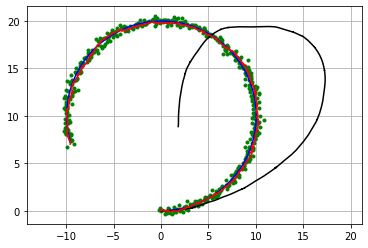

In [32]:
from utils import observation

mainEKF()

<img src='../gifs/ekf-final.gif'></img>

<h4> 2.1. Unscented Kalman Filter </h4>

À semelhança do EKF, o UKF é um algoritmo para modelos não-lineares, contudo, são geralmente mais precisos, pois são gerados sigma-points (SP) e respetivos pesos, que depois de sofrerem as transformações que o modelo real sofreu, aproximam-se mais da realidade, seguindo também uma distribuição maioritariamente gaussiana.
Depois, prevê os valores de maneira semelhante ao Kalman Filter (e, por consequência, ao EKF).

Este filtro compreende 4 fases:
<ul>
    <li>Inicialização</li>
    <li>Geração dos SPs</li>
    <li>Previsão do estado dos SPs </li>
    <li>Previsão do estado do robot com base no estado dos SP</li>
    <li>[ completar!! ]</li>
</ul>

In [33]:
def mainUKF(show_plot=True):
    # print('Robot sim initiated!')
    L = 4
    xpred = np.zeros((L, 1))
    xtrue = np.zeros((L, 1))
    ppred = np.eye(L)
    wm, wP, gamma = initWeights(L)
    xdr = np.zeros((L, 1))

    # history 
    hxpred = xpred
    hxtrue = xtrue
    hxdr = xdr
    hz = np.zeros((2, 1))

    time = 0.0

    if show_plot:
        fig = plt.figure()
        fig.show()

    while time <= sim_time:
        time += dt

        xtrue, z, xdr, ud = observation2(xtrue, xdr, u())
        xpred, ppred = ukf(xpred, ppred, z, ud, wm, wP, gamma)
        # hxpred, hxdr, hxtrue, hz = save(hxpred, xpred, hxdr, xdr, hxtrue, xtrue, hz, z)
        hxpred = np.hstack((hxpred, xpred))
        hxdr = np.hstack((hxdr, xdr))
        hxtrue = np.hstack((hxtrue, xtrue))
        hz = np.vstack((hz, z))

    if show_plot:
        plt.plot(hz[0, :], hz[1, :], ".g")
        plt.plot(hxtrue[0, :].flatten(), hxtrue[1, :].flatten(), "-b")
        plt.plot(hxdr[0, :].flatten(), hxdr[1, :].flatten(), "-k")
        plt.plot(hxpred[0, :].flatten(), hxpred[1, :].flatten(), "-r")
        plt.axis("equal")
        plt.grid(True)

    return hxpred, hxtrue, hxdr

C:\Users\MANUEL~1\AppData\Local\Temp/ipykernel_3644/2516241863.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(array([[ 0.        ,  0.24041646,  0.09138621, ..., -9.67168033,
         -9.63237064, -9.63050017],
        [ 0.        , -0.12232774, -0.08821927, ...,  7.09825507,
          7.15441716,  7.09740789],
        [ 0.        ,  0.02622233,  0.02162869, ...,  4.77700187,
          4.76788872,  4.7651303 ],
        [ 0.        , -0.25575275, -0.67798157, ...,  2.3904499 ,
         -0.40407164,  0.96460826]]),
 array([[ 0.00000000e+00,  1.00000000e-01,  1.99995000e-01, ...,
         -9.60719466e+00, -9.58075184e+00, -9.55334595e+00],
        [ 0.00000000e+00,  0.00000000e+00,  9.99983333e-04, ...,
          7.40387649e+00,  7.30743595e+00,  7.21126466e+00],
        [ 0.00000000e+00,  1.00000000e-02,  2.00000000e-02, ...,
          4.98000000e+00,  4.99000000e+00,  5.00000000e+00],
        [ 0.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
          1.00000000e+00,  1.00000000e+00,  1.00000000e+00]]),
 array([[ 0.00000000e+00, -2.55752749e-02, -9.33501242e-02, ...,
         -1.3156231

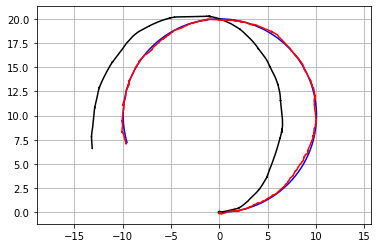

In [34]:
mainUKF()

<img src='../gifs/ukf-final.gif'></img>

<h4> 2.2. Particle Filter </h4>

Até aqui, vimos filtros que determinavam a posição do robot através de previsões e comparações com dados reais. O *Particle Filter* (PF) segue uma abordagem diferente:
<ul>
    <li>
        Usando um número qualquer de pontos de referência, gera-se uma 'nuvem' de possíveis posições arbitrárias que o robot pode assumir (partículas). Nesta fase, assume-se que todas as partículas têm igual probabilidade de representar a posição do robot.
    </li>
    <li>
        Para cada partícula, calcula-se a probabilidade da mesma corresponder à posição real (i.e medida com o sensor GPS) do robot. No nosso caso, isto é feito através do cálculo da distância euclidiana da partícula ao robot - quanto maior a distância, menor a probabilidade de corresponder à posição do robot. Neste processo, é também utilizada a distância aos pontos de referência pré-definidos.
    </li>
    <li>
        Atualizam-se os pesos das partículas conforme as probabilidades calculadas no passo anterior.
    </li>
    <li>
        Calcula-se a nova distribuição de probabilidades associada às partículas com maior peso (i.e as que têm maior probabilidade de corresponder à real posição do robot).
    </li>
    <li>
        Atualizar a 'nuvem' de partículas, segundo a distribuição de probabilidades calculada em 4. Este passo garante que há mais partículas nos sítios onde é mais provável o robot estar posicionado.
    </li>
    <li>
        'Mover' as partículas de acordo com o vetor u (velocidade, taxa de viragem) + ruído de medição.
    </li>
    <li>
        Este processo repete-se até ao fim do tempo definido.
    </li>
</ul>

Ao longo da simulação, espera-se que a nuvem de partículas vá convergindo para a posição real do robot.

O código-fonte para a implementação deste filtro foi baseado <a href='https://github.com/AtsushiSakai/PythonRobotics/blob/af2061a1e784a6779bdc08976a43157ddae17884/Localization/particle_filter/particle_filter.py#L105'>neste repositório</a>

<img src='../images/pf-final.png'></img>

<img src='../gifs/pf-final.gif'></img>

Com o objetivo de descobrir um pouco mais acerca deste algoritmo, coloquei três questões acerca dos seus parâmetros iniciais:
<ul>
    <li>
        Como varia o erro em função do número de partículas?
    </li>
    <li>
        Como varia o erro em função do número de pontos de referência?
    </li>
    <li>
        Qual é o efeito do aumento destes parâmetros no tempo de execução do algoritmo? Qual é zona ótima no trade-off entre tempo e precisão?
    </li>
</ul>

Para as questões acima, hipotetizei que, quanto maior o número de pontos de referência ou partículas, menor o erro. No entanto, previ que este aumento afetasse negativamente o tempo de execução.

<img src='../images/pf-time-vs-particle-count.png'></img>

<img src='../images/pf-metrics-vs-particle-count.png'></img>

## Comparação dos algoritmos

In [42]:
# EKF
 
ekf_mse_array = []
ekf_rmse_array = []
ekf_r2_array = []

print('Calculating 25 EKF...')
for i in range(25):
    ekf_hxpred, ekf_hxtrue, ekf_hxdr = mainEKF(show_plot=False)
    ekf_mse_array += [
        (
            mse(ekf_hxtrue.T[:, :2], ekf_hxdr.T[:, :2]),
            mse(ekf_hxtrue.T[:, :2], ekf_hxpred.T[:, :2])
        )
    ]
    ekf_rmse_array += [
        (
            sqrt(mse(ekf_hxtrue.T[:, :2], ekf_hxdr.T[:, :2])),
            sqrt(mse(ekf_hxtrue.T[:, :2], ekf_hxpred.T[:, :2]))
        )
    ]
    ekf_r2_array += [
        (
            r2(ekf_hxtrue.T[:, :2], ekf_hxdr.T[:, :2]),
            r2(ekf_hxtrue.T[:, :2], ekf_hxpred.T[:, :2])
        )
    ]
print('Done!')

Calculating 25 EKF...
Done!


In [43]:
# UKF

ukf_mse_array = []
ukf_rmse_array = []
ukf_r2_array = []

print('Calculating 25 UKF...')
for i in range(25):
    ukf_hxpred, ukf_hxtrue, ukf_hxdr = mainEKF(show_plot=False)
    ukf_mse_array += [
        (
            mse(ukf_hxtrue.T[:, :2], ukf_hxdr.T[:, :2]),
            mse(ukf_hxtrue.T[:, :2], ukf_hxpred.T[:, :2])
        )
    ]
    ukf_rmse_array += [
        (
            sqrt(mse(ukf_hxtrue.T[:, :2], ukf_hxdr.T[:, :2])),
            sqrt(mse(ukf_hxtrue.T[:, :2], ukf_hxpred.T[:, :2]))
        )
    ]
    ukf_r2_array += [
        (
            r2(ukf_hxtrue.T[:, :2], ukf_hxdr.T[:, :2]),
            r2(ukf_hxtrue.T[:, :2], ukf_hxpred.T[:, :2])
        )
    ]
print('Done!')

Calculating 25 UKF...
Done!


In [52]:
ekf_mse_df = pd.DataFrame(ekf_mse_array).rename(columns={0: 'DR', 1:'EKF'})
ekf_rmse_df = pd.DataFrame(ekf_rmse_array).rename(columns={0: 'DR', 1:'EKF'})
ekf_r2_df = pd.DataFrame(ekf_r2_array).rename(columns={0: 'DR', 1:'EKF'})

In [97]:
# Metrics dataframes
# MSE
ukf_mse_df = pd.DataFrame(ukf_mse_array).rename(columns={0: 'DR', 1:'UKF'})
ekf_mse_df['UKF'] = ukf_mse_df['UKF']
mse_df = ekf_mse_df.describe().iloc[1:3, :]
mse_df = mse_df.T.rename(columns={'mean':'mse_mean', 'std':'mse_std'})

# RMSE
ukf_rmse_df = pd.DataFrame(ukf_rmse_array).rename(columns={0: 'DR', 1:'UKF'})
ekf_rmse_df['UKF'] = ukf_rmse_df['UKF']
rmse_df = ekf_rmse_df.describe().iloc[1:3, :]
rmse_df = rmse_df.T.rename(columns={'mean':'rmse_mean', 'std':'rmse_std'})

# R2
ukf_r2_df = pd.DataFrame(ukf_r2_array).rename(columns={0: 'DR', 1:'UKF'})
ekf_r2_df['UKF'] = ukf_r2_df['UKF']
r2_df = ekf_r2_df.describe().iloc[1:3, :]
r2_df = r2_df.T.rename(columns={'mean':'r2_mean', 'std':'r2_std'})

In [112]:
metrics = pd.concat([mse_df, rmse_df, r2_df], axis=1)
metrics = metrics.append(pd.DataFrame([[0.013390, 0.001474, 0.115547, 0.006346, 0.999714, 0.000032]], columns=metrics.columns, index=['PF']))

C:\Users\MANUEL~1\AppData\Local\Temp/ipykernel_3644/311530990.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd.DataFrame([[0.013390, 0.001474, 0.115547, 0.006346, 0.999714, 0.000032]], columns=metrics.columns, index=['PF']))


In [113]:
metrics

,mse_mean,mse_std,rmse_mean,rmse_std,r2_mean,r2_std
DR,20.647242,19.275087,4.054986,2.092728,0.554838,0.419756
EKF,0.020470,0.003227,0.142657,0.011129,0.999565,0.000067
UKF,0.018861,0.004196,0.136530,0.015174,0.999598,0.000091
PF,0.013390,0.001474,0.115547,0.006346,0.999714,0.000032
